# Toy Example of Muti-task Learning

Here, we would like to show a classic and interesting toy example of multi-task learning (MTL). 

<a target="_blank" href="https://colab.research.google.com/github/tum-pbs/ConFIG/blob/main/docs/examples/mtl_toy.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this example, there are two tasks represented by two loss functions, which are

In [1]:
import torch

LOWER = 0.000005
def landscape(x,y):
    l1 = torch.clamp((0.5 * (-x - 7) - torch.tanh(-y)).abs(), LOWER).log() + 6
    l1_sq = ((-x+ 7).pow(2) + 0.1 * (-y - 8).pow(2)) / 10 - 20
    l2 = torch.clamp((0.5 * (-x+ 3) + torch.tanh(-y) + 2).abs(), LOWER).log() + 6
    l2_sq = ((-x- 7).pow(2) + 0.1 * (-y - 8).pow(2)) / 10 - 20
    c1 = torch.clamp(torch.tanh(y * 0.5), 0)
    c2 = torch.clamp(torch.tanh(-y * 0.5), 0)
    l1 = l1 * c1 + l1_sq * c2
    l2 = l2 * c1 + l2_sq * c2
    return l1,l2 

We can visualize the loss function below:

/home/liu/anaconda3/envs/deeplearning/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


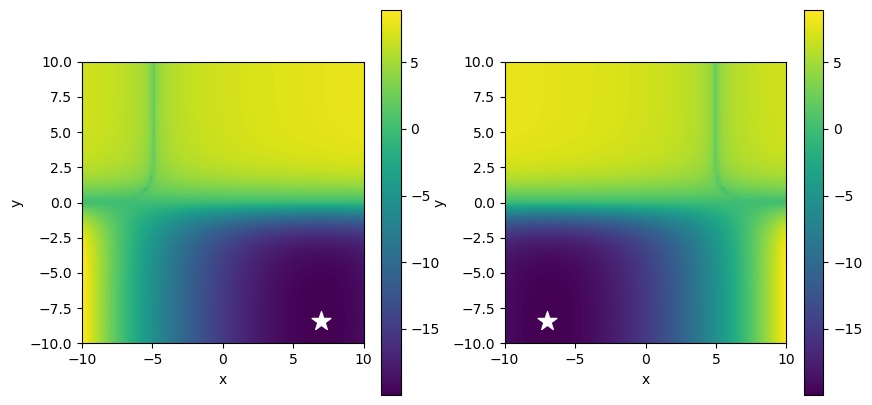

In [2]:
import matplotlib.pyplot as plt

MARKERS=['o','s','^','x','*', 'D', 'v', '<', '>', 'p', 'h']
def plot_landscape(trajectories=None,
                   field="all",
                   scale=[1,1],
                   ax=None,
                   c_bar=True):
    x,y=torch.meshgrid(torch.linspace(-10,10,100),torch.linspace(-10,10,100))
    l1,l2=landscape(x,y)
    l1=l1*scale[0]
    l2=l2*scale[1]
    if field == "l1":
        value = l1
    elif field == "l2":
        value = l2
    elif field == "all":
        value = l1+l2
    if ax is None:
        ax = plt.gca()
    im=ax.imshow(value.T, extent=(-10, 10, -10, 10),origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if c_bar:
        plt.colorbar(im,ax=ax)
    if trajectories is not None:
        for i,trajectory in enumerate(trajectories):
            ax.scatter([t[0] for t in trajectory], [t[1] for t in trajectory],
                       c=[i for i in range(len(trajectory))],cmap='autumn_r',marker=MARKERS[i])
            ax.scatter([trajectory[0][0]], [trajectory[0][1]],
                       c="black",marker=MARKERS[i])
    if ax is None:
        plt.show()
        
fig,axs=plt.subplots(1,2,figsize=(10,5))
plot_landscape(field="l1",ax=axs[0])
axs[0].scatter([7],[-8.43],marker='*',color='white',s=200)
plot_landscape(field="l2",ax=axs[1])
axs[1].scatter([-7],[-8.43],marker='*',color='white',s=200)
plt.show()

The two loss landscapes are mirror images of each other. The minimum point of two loss function are $(7,-8.43)$ and $(-7,-8.43)$ respectively. To further increase the challenge to the optimization, we will rescale `l1` with 0.1. Then, the optimization becomes unbalanced where the gradient of `l1` is much smaller than `l2`. The final loss landscape looks like this:

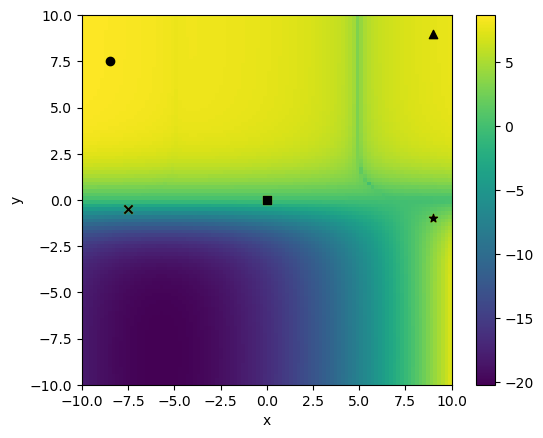

In [3]:
inits = [
    torch.Tensor([-8.5, 7.5]),
    torch.Tensor([0.0, 0.0]),
    torch.Tensor([9.0, 9.0]),
    torch.Tensor([-7.5, -0.5]),
    torch.Tensor([9, -1.0]),
]

plot_landscape(field="all",trajectories=[[point] for point in inits],scale=[0.1,1])

The five `init` points represent the five initial points for our optimization. 


In MTL, the final target is not to reach a point with minimal total loss but to reach the [Pareto_frontier](https://en.wikipedia.org/wiki/Pareto_front). The Pareto frontier is the set of all Pareto efficient points. A point is Pareto efficient if there is no other point that is better in all objectives. In our case, this means the point where any attempt to decrease one loss will increase the other loss. We can easily visualize the Pareto frontier in the loss landscape by plotting the losses at each point in a 2D plane:

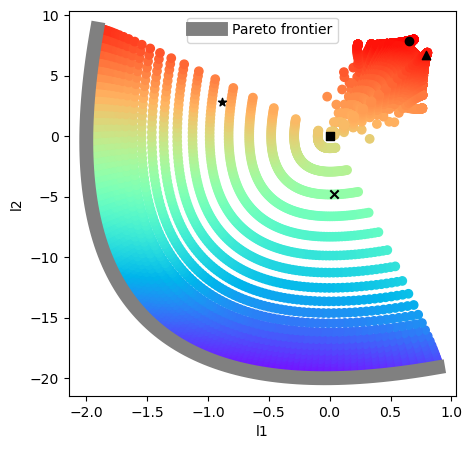

In [4]:
plt.figure(figsize=(5,5))
x,y=torch.meshgrid(torch.linspace(-10,10,100),torch.linspace(-10,10,100))
l1,l2=landscape(x,y)
l1=0.1*l1
plt.scatter(l1.view(-1),l2.view(-1),c=(l1+l2).view(-1),cmap='rainbow')

x=torch.linspace(10,-10,100)
y=torch.ones(100)*-8.43
l1,l2=landscape(x,y)
plt.plot(0.1*l1,l2,c="Gray",linewidth=10,label="Pareto frontier")

for i,init in enumerate(inits):
    l1,l2=landscape(init[0],init[1])
    plt.scatter(0.1*l1,l2,marker=MARKERS[i],c="black")
    

plt.xlabel("l1")
plt.ylabel("l2")
plt.legend()
plt.show()

Now, lets first use the 'Adam' optimizer to solve this problem:

100%|██████████| 50000/50000 [00:44<00:00, 1115.74it/s]


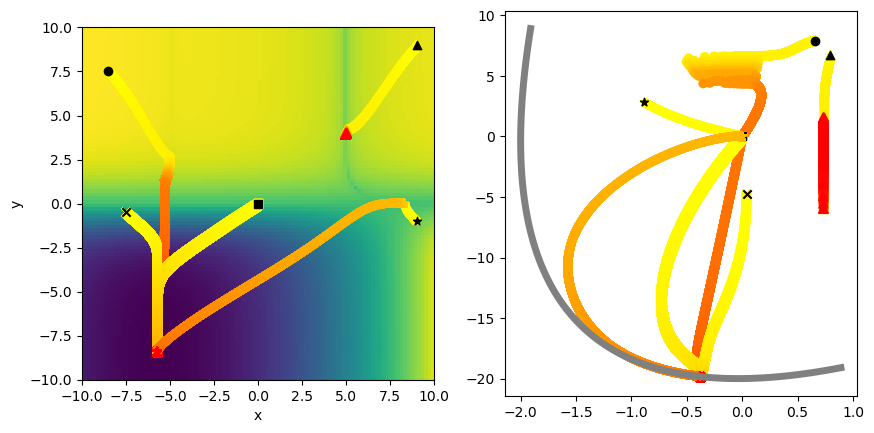

In [5]:
def plot_pareto_front(loss_trajectories=None,ax=None,scale=[1,1]):
    x=torch.linspace(10,-10,100)
    y=torch.ones(100)*-8.43
    l1,l2=landscape(x,y)
    if ax is None:
        fig=plt.figure(figsize=(5,5))
        ax = plt.gca()
    ax.plot(scale[0]*l1,scale[1]*l2,c="Gray",linewidth=5)
    if loss_trajectories is not None:
        for i,trajectory in enumerate(loss_trajectories):
            ax.scatter([t[0] for t in trajectory], [t[1] for t in trajectory],
                       c=[i for i in range(len(trajectory))],cmap='autumn_r',marker=MARKERS[i])
            ax.scatter([trajectory[0][0]], [trajectory[0][1]],
                       c="black",marker=MARKERS[i])
    if ax is None:
        plt.show()

from tqdm import tqdm
scale=[0.1,1]
trajectories = [];losses = []
for init in inits:
    trajectory_i = []
    loss_i= []
    x = init[0].clone().requires_grad_(True)
    y = init[1].clone().requires_grad_(True)
    optimizer = torch.optim.Adam([x,y], lr=1e-3)
    for i in tqdm(range(50000)):
        optimizer.zero_grad()
        l1,l2 = landscape(x,y)
        loss = scale[0]*l1 + scale[1]*l2
        trajectory_i.append((x.item(),y.item()))
        loss_i.append((scale[0]*l1.item(),scale[1]*l2.item()))
        loss.backward()
        optimizer.step()
    trajectories.append(trajectory_i)
    losses.append(loss_i)
  
fig,axs=plt.subplots(1,2,figsize=(10,5))
plot_landscape(field="all",trajectories=trajectories,scale=scale,ax=axs[0],c_bar=False)
plot_pareto_front(losses,scale=scale,ax=axs[1])  
plt.show()

The color in the optimization strategy represents the index of the optimization step, where yellow is the start of the optimization and red represents the end. For the Adam optimizer, the optimization starts with initial points of $\bullet $, $\Box$, $\star$, and $\times$ converges to the Pareto frontier while the trajectory starts with $\bigtriangleup$ is stuck in a local minimum of l2. This is because the gradient of l1 is much smaller than l2, so the optimization is biased towards l2. This can also be seen from the trajectories of other points. The optimization with the initial point of $\star$ first goes to the minimum of l2 and then moves to the Pareto frontier. Also, other optimization trajectories are biased towards points on the Pareto frontier where l2 is smaller.

Now, let's try on our ConFIG method:

  0%|          | 82/50000 [00:00<01:01, 811.31it/s]

100%|██████████| 50000/50000 [01:01<00:00, 815.54it/s]


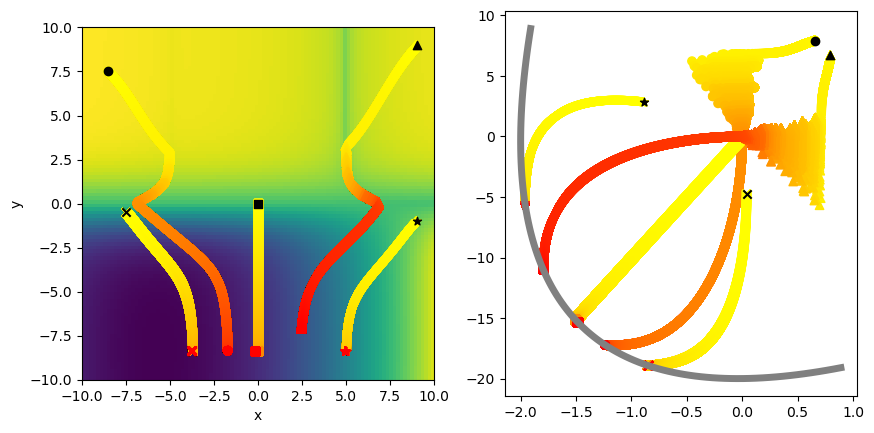

In [6]:
from tqdm import tqdm
from ConFIG.grad_operator import ConFIG_update
scale=[0.1,1]
trajectories = [];losses = []
for init in inits:
    trajectory_i = []
    loss_i= []
    x = init[0].clone().requires_grad_(True)
    y = init[1].clone().requires_grad_(True)
    optimizer = torch.optim.Adam([x,y], lr=1e-3)
    for i in tqdm(range(50000)):
        optimizer.zero_grad()
        l1,l2 = landscape(x,y)
        trajectory_i.append((x.item(),y.item()))
        loss_i.append((scale[0]*l1.item(),scale[1]*l2.item()))
        
        (scale[0]*l1).backward(retain_graph=True)
        grad_1 = torch.cat([x.grad.view(-1),y.grad.view(-1)])
        x.grad.data.zero_()
        y.grad.data.zero_()
        (scale[1]*l2).backward()
        grad_2 = torch.cat([x.grad.view(-1),y.grad.view(-1)])
        x.grad.data.zero_()
        y.grad.data.zero_()
        g_config=ConFIG_update([grad_1,grad_2])
        x.grad.data = g_config[0].view_as(x)
        y.grad.data = g_config[1].view_as(y)
        
        optimizer.step()
    trajectories.append(trajectory_i)
    losses.append(loss_i)
    
fig,axs=plt.subplots(1,2,figsize=(10,5))
plot_landscape(field="all",trajectories=trajectories,scale=scale,ax=axs[0],c_bar=False)
plot_pareto_front(losses,scale=scale,ax=axs[1])  

All the optimization trajectories here converge to the Pareto frontier. This is because ConFIG tries to find a conflict-free gradient direction for each task. This not only makes the trajectory  $\bigtriangleup$ jump out of the local minimum of l2 but also makes the optimization trajectory of $\star$ converge to the Pareto frontier more directly.

Now, lets try the momentum version of ConFIG:

100%|██████████| 50000/50000 [00:53<00:00, 938.95it/s]


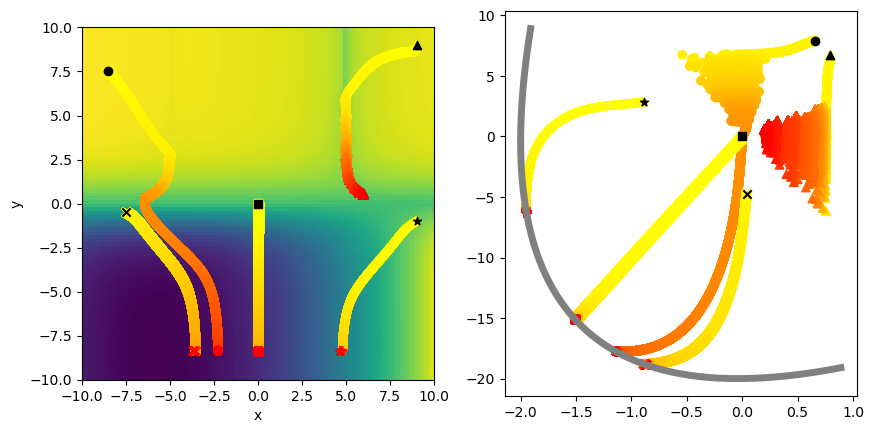

In [8]:
from tqdm import tqdm
from ConFIG.momentum_operator import PseudoMomentumOperator

scale=[0.1,1]
trajectories = [];losses = []
momentum_operator = PseudoMomentumOperator(num_vectors=2)
for init in inits:
    trajectory_i = []
    loss_i= []
    x = init[0].clone().requires_grad_(True)
    y = init[1].clone().requires_grad_(True)
    optimizer = torch.optim.SGD([x,y], lr=1e-3)
    for i in tqdm(range(50000)):
        optimizer.zero_grad()
        l1,l2 = landscape(x,y)
        trajectory_i.append((x.item(),y.item()))
        loss_i.append((scale[0]*l1.item(),scale[1]*l2.item()))
        
        if i%2==0:
            (scale[0]*l1).backward()
            grad_1 = torch.cat([x.grad.view(-1),y.grad.view(-1)])
            g_config=momentum_operator.calculate_gradient(0,grad_1)
        else:
            (scale[1]*l2).backward()
            grad_2 = torch.cat([x.grad.view(-1),y.grad.view(-1)])
            g_config=momentum_operator.calculate_gradient(1,grad_2)
        x.grad.data = g_config[0].view_as(x)
        y.grad.data = g_config[1].view_as(y)
        
        optimizer.step()
    trajectories.append(trajectory_i)
    losses.append(loss_i)
    
fig,axs=plt.subplots(1,2,figsize=(10,5))
plot_landscape(field="all",trajectories=trajectories,scale=scale,ax=axs[0],c_bar=False)
plot_pareto_front(losses,scale=scale,ax=axs[1])  

The results are similar to ConFIG while it needs more iterations to converge. This is due to we only update a single gradient direction every iteration. The acceleration of the momentum version is not so significant in this case since the backpropagation of gradients is not the main bottleneck of the optimization.